In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
from PIfunc import PIfunc
from EqualState import EqualState

In [3]:
#main
Tot=300
dt=1./60
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau=20/2.12**2
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [4]:
x = LPOU  ##HMM or OU or LPOU
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
v=v[1:-1]
# v =np.diff(x)/dt
# v=v[0:-1] #cut ends.  V(n) = X(n) -X(n-1)
x=x[1:-1]
T=T[1:-1]

(140, 160)

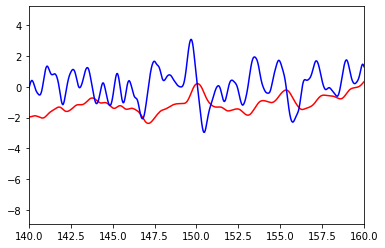

In [5]:
x_n = (x-np.mean(x))/np.std(x)
v_n = (v-np.mean(v))/np.std(v)
plt.plot(T,x_n, 'r-')
plt.plot(T,v_n, 'b-')
plt.xlim(140,160)

0.61666666666666

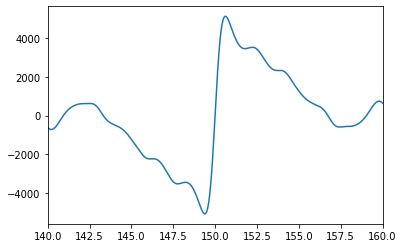

In [6]:
xv_cor = np.correlate(x_n, v_n, "same")

plt.plot(T,xv_cor)
plt.xlim(140,160)
# Taxis = np.flip(T[:len(xv_cor)]-dt/2)
# t_cor = np.interp(0.5*max(xv_cor),  xv_cor, Taxis)
# t_cor
np.squeeze(T[np.where(xv_cor == max(xv_cor))]-T[np.where(xv_cor == min(xv_cor))])/2

In [7]:
# plt.plot(T,L[1:-1], 'r-')
# plt.plot(T,x, 'b-')
# plt.xlim(150,160)
# plt.gcf().set_size_inches(10.7, 6)
# plt.legend( (r'$OU$', r'$LPOU(1Hz)$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.show()

In [30]:
##response
# Model one: simple estimation
deltaT = 0.8
r = x+v*deltaT
#assign states
rstate=np.zeros(len(r))

##'fake distributed'
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)

##'randomly not fire' + 'burst distributed' 
# counter = 0
# burst_distr = np.array([0.95, 0.03, 0.02]);
# for n in np.arange(1,3):
#     edge = np.sort(r)[int(counter)]
#     counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
#     rstate[r>=edge] = n
# randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
# np.random.shuffle(randomly_not_fire)
# rstate = rstate*randomly_not_fire
# rstate = rstate.astype(int)

##equal state
# rstate, edges = EqualState(r, 6)

In [31]:
xr_cor = np.correlate(x_n, r, "same")
(np.squeeze(np.where(xr_cor == max(xr_cor)))-len(T)/2)*dt

0.375

In [32]:
#assign states
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)

In [33]:
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: divide by zero encountered in log2
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: invalid value encountered in multiply
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:54: RuntimeWarning: divide by zero encountered in log2
  MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:54: RuntimeWarning: invalid value encountered in multiply
  MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: divide by zero encountered in log2
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: invalid value encountered in multiply
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Docu

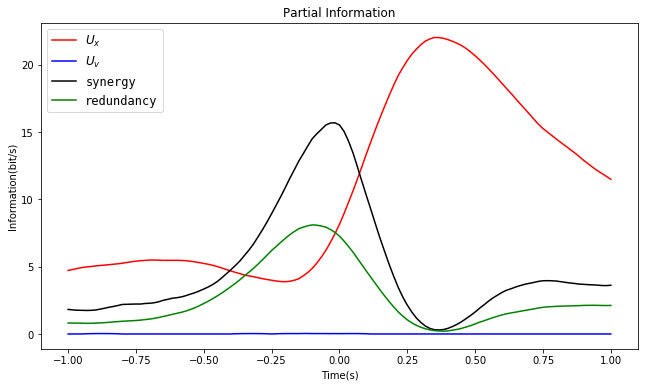

In [34]:
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title('Partial Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_PI.tiff')

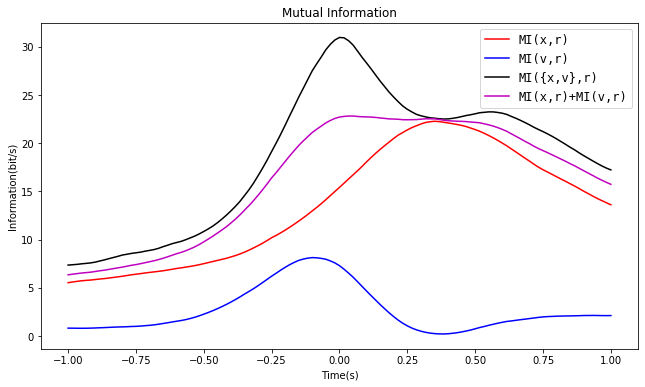

In [35]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

In [13]:
window = [-2,2] # second
timeshift, MIxx, MIxv, MIxjoint, xRedun = PIfunc(xstate, xstate, vstate, dt, window)
Uxx = MIxx-xRedun
Uxv = MIxv-xRedun
xSyner = MIxjoint-MIxx-MIxv+xRedun

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: divide by zero encountered in log2
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: invalid value encountered in multiply
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: divide by zero encountered in log2
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: invalid value encountered in multiply
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:57: RuntimeWarning: divide by zero encountered in log2
  PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:57: RuntimeWarning: invalid value encountered in multiply
  PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))


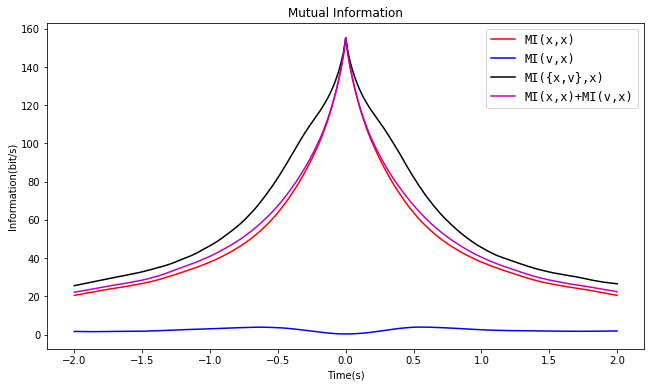

In [14]:
#plot MIs
plt.plot(timeshift,MIxx, 'r-')
plt.plot(timeshift,MIxv, 'b-')
plt.plot(timeshift,MIxjoint, 'k-')
plt.plot(timeshift,MIxx+MIxv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,x)', 'MI(v,x)', 'MI({x,v},x)', 'MI(x,x)+MI(v,x)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')